In [2]:
%load_ext autoreload
%autoreload 2

import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
from data_loader import load_mefisto_evodevo

from famo.plotting import (
    plot_training_curve,
    plot_variance_explained,
)
from famo.utils_io import load_model

warnings.simplefilter(action="ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
data = load_mefisto_evodevo()

In [3]:
# model = CORE(device="cuda")
# model.fit(
#     n_factors=5,
#     data=data,
#     factor_prior="GP",
#     weight_prior="ARD_Spike_and_Slab",
#     covariates_obs_key="time",
#     lr=0.005,
#     early_stopper_patience=500,
#     print_every=100,
#     center_groups=True,
#     scale_views=False,
#     scale_groups=True,
#     max_epochs=10000,
#     save=True,
#     save_path="trained_model",
#     init_factors="random",
#     init_scale=0.1,
# )

model = load_model("trained_model")

Model loaded from trained_model/model.pkl
Parameters loaded from trained_model/params.save


In [4]:
plot_training_curve(model)

alt.Chart(...)

In [8]:
plot_variance_explained(model)

alt.HConcatChart(...)

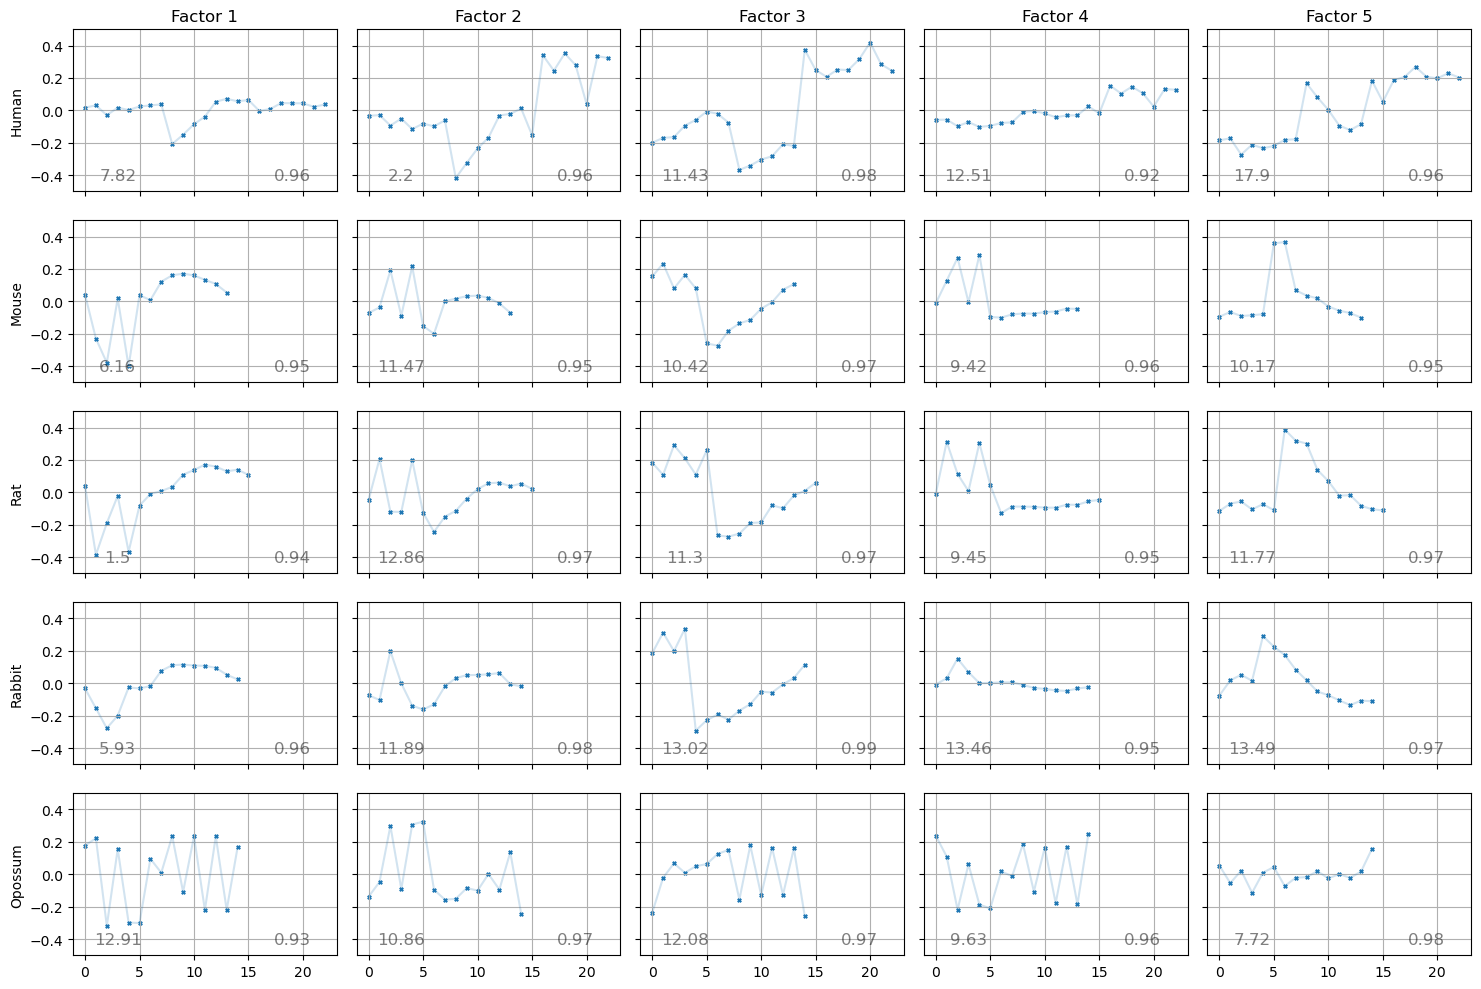

In [17]:
z = model.get_factors()

fig, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True, sharey=True)

for factor in range(5):
    for i, group in enumerate(z.keys()):
        axs[i][0].set_ylabel(group)
        z_group_factor = z[group].iloc[:, factor]
        ax = axs[i][factor]
        ax.plot(np.arange(z_group_factor.shape[0]), z_group_factor, label=group, alpha=.2)
        ax.scatter(np.arange(z_group_factor.shape[0]), z_group_factor, s=6, marker="x")
        ax.grid()
        ax.set_ylim(-0.5, 0.5)
        ax.text(19, -0.4, f'{round(model.gps[group].eval().covar_module.outputscale.cpu().detach()[factor].item(), 2)}', ha='center', va='center', alpha=0.5, size=12)
        ax.text(3, -0.4, f'{round(model.gps[group].eval().covar_module.base_kernel.lengthscale.cpu().detach()[factor].item(), 2)}', ha='center', va='center', alpha=0.5, size=12)
    axs[0][factor].set_title(f"Factor {factor + 1}")

plt.tight_layout()
plt.show()

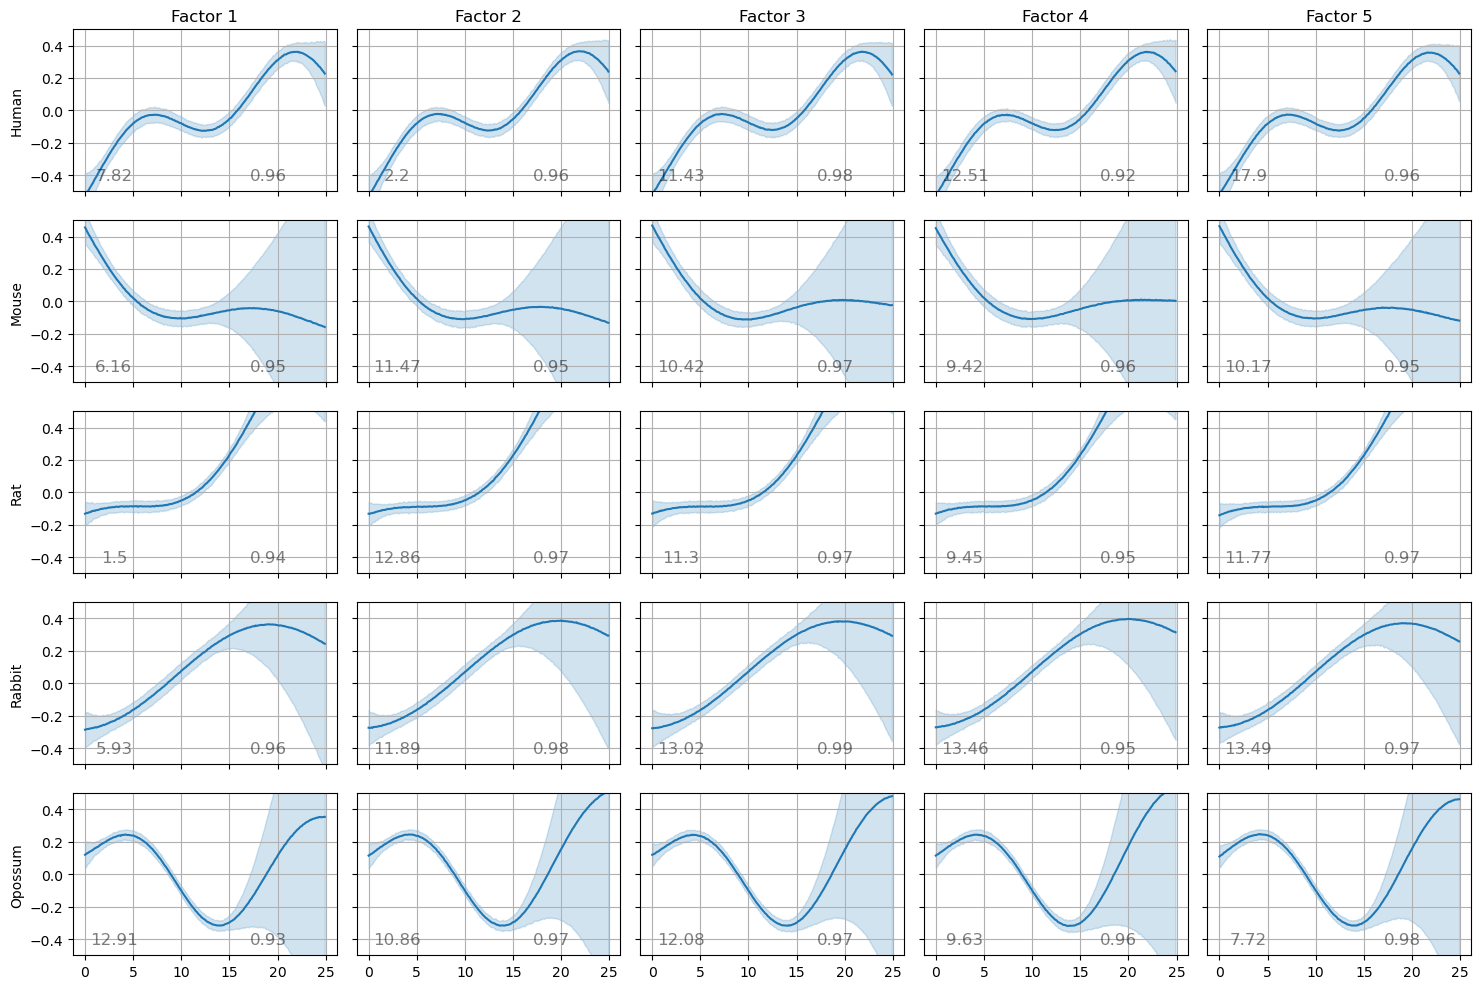

In [22]:
fig, axs = plt.subplots(5, 5, figsize=(15, 10), sharex=True, sharey=True)

x = torch.arange(0, 25, 0.1)
for factor in range(5):
    for i, group in enumerate(z.keys()):
        axs[i][0].set_ylabel(group)
        gp = model.gps[group]
        samples = gp(x.to(model.device), prior=False).sample(torch.Size([100]))
        mean = samples.mean(axis=0)[i].cpu().detach().numpy()
        std = samples.std(axis=0)[i].cpu().detach().numpy()
        lower_bound = mean - 1.96 * std
        upper_bound = mean + 1.96 * std
        ax = axs[i][factor]
        ax.plot(x, mean, label=group)
        ax.fill_between(x, lower_bound, upper_bound, color='C0', alpha=0.2, label='95% CI')
        ax.grid()
        ax.set_ylim(-0.5, 0.5)
        ax.text(19, -0.4, f'{round(model.gps[group].eval().covar_module.outputscale.cpu().detach()[factor].item(), 2)}', ha='center', va='center', alpha=0.5, size=12)
        ax.text(3, -0.4, f'{round(model.gps[group].eval().covar_module.base_kernel.lengthscale.cpu().detach()[factor].item(), 2)}', ha='center', va='center', alpha=0.5, size=12)
    axs[0][factor].set_title(f"Factor {factor + 1}")

plt.tight_layout()
plt.show()